In [19]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  LeNet ##

In [21]:
import os

os.makedirs("dl", exist_ok = True)

for fname in [
    "MnistDataset.py",
    "main.py",
    "main_lenet.py",
]:
  open(f"dl/{fname}", "w").close()

In [22]:
%%writefile dl/MnistDataset.py
import torch
from torch.utils.data import Dataset
import idx2numpy
import numpy as np

# Nhập các dòng dữ liệu
def collate_fn(items: list[dict]) -> dict[torch.Tensor]:
    # Gom lại thành batch
    images = np.stack([item["image"] for item in items], axis=0)
    labels = np.array([int(item["label"]) for item in items], dtype=np.int64)

    data = {
        "image": torch.tensor(images, dtype=torch.float32),
        "label": torch.tensor(labels, dtype=torch.int64)
    }

    return data

class MnistDataset(Dataset):
    def __init__(self, image_path: str, label_path: str):
        images = idx2numpy.convert_from_file(image_path)
        labels = idx2numpy.convert_from_file(label_path)

        self._data = [
            {"image": image.astype(np.float32).reshape(-1), "label": int(label)}
            for image, label in zip(images, labels)
        ]

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx: int) -> dict:
        return self._data[idx]

Overwriting dl/MnistDataset.py


In [23]:
%%writefile dl/LeNet.py
import torch
from torch import nn
from torch.nn import functional as F

class LeNet(nn.Module):
    def __init__(self, image_size: tuple):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 6,
            kernel_size = (5,5),
            padding = (2,2)
        )

        self.pooling1 = nn.AvgPool2d(
            kernel_size = (2,2),
            stride = (2,2)
        )

        self.conv2 = nn.Conv2d(
            in_channels = 6,
            out_channels = 16,
            kernel_size = (5,5)
        )

        self.pooling2 = nn.AvgPool2d(
            kernel_size = (2,2),
            stride = (2,2)
        )

        self.conv3 = nn.Conv2d(
            in_channels = 16,
            out_channels = 120,
            kernel_size = (5,5)
        )

        self.fc = nn.Linear(
            in_features = 120,
            out_features = 84
        )

        self.output = nn.Linear(
            in_features = 84,
            out_features = 10
        )

    def forward(self, images: torch.Tensor):
        # Input ảnh có size (bs, 28, 28)
        # thêm channel dimension -> (bs, 1, 28, 28)
        images = images.view(-1, 1, 28, 28)

        features = F.sigmoid(self.conv1(images))
        features = self.pooling1(features)
        features = F.sigmoid(self.conv2(features))
        features = self.pooling2(features)
        features = F.sigmoid(self.conv3(features))

        # Dùng squeeze để "flatten" tensor từ (bs, 120, 1, 1) -> (bs, 120)
        features = features.squeeze(-1).squeeze(-1)

        features = F.sigmoid(self.fc(features))
        logits = self.output(features) # (bs, 10)

        return logits

Overwriting dl/LeNet.py


In [24]:
%%writefile dl/main_lenet.py
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import numpy as np
import os
import torchvision.transforms as transforms
from MnistDataset import collate_fn as mnist_collate_fn, MnistDataset
from LeNet import LeNet
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = "/content/drive/MyDrive/Kì 1 - Năm 3/DS200/DL-LAB2"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- Các hàm helper ---
def evaluate(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> dict:
    model.eval()
    predicts = []
    labels_list = []
    losses = []

    with torch.no_grad():
        for item in dataloader:
            image = item["image"].to(device)
            label = item["label"].to(device)
            output = model(image)

            loss = loss_fn(output, label)
            losses.append(loss.item())
            output = output.argmax(dim=-1)

            predicts.extend(output.cpu().numpy())
            labels_list.extend(label.cpu().numpy())

    return {
        "loss": np.array(losses).mean(),
        "accuracy": accuracy_score(labels_list, predicts),
        "precision": precision_score(labels_list, predicts, average="macro", zero_division=0),
        "recall": recall_score(labels_list, predicts, average="macro", zero_division=0),
        "f1": f1_score(labels_list, predicts, average="macro", zero_division=0)
    }

def print_digit_metrics(predicts, labels_list, num_classes):
    print(f"\nBảng kết quả từng lớp (total: {num_classes} lớp):")
    print("Class | Precision | Recall | F1-Score")
    print("-" * 45)

    precision = precision_score(labels_list, predicts, average=None, zero_division=0)
    recall = recall_score(labels_list, predicts, average=None, zero_division=0)
    f1 = f1_score(labels_list, predicts, average=None, zero_division=0)

    for i in range(num_classes):
        prec = precision[i] if i < len(precision) else 0.0
        rec = recall[i] if i < len(recall) else 0.0
        f1_s = f1[i] if i < len(f1) else 0.0
        print(f"{i:5d} | {prec:.4f}     | {rec:.4f} | {f1_s:.4f}")

def save_checkpoint(epoch, model, optimizer, best_score, best_score_name, filename):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_score': best_score,
        'best_score_name': best_score_name,
    }, checkpoint_path)
    print(f"-> Checkpoint được lưu ở {checkpoint_path}")

def load_checkpoint(model, optimizer, filename):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)
    start_epoch = 0
    best_score = 0
    best_score_name = "accuracy"

    if os.path.exists(checkpoint_path):
        print(f"-> Tải checkpoint từ {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_score = checkpoint.get('best_score', 0)
        best_score_name = checkpoint.get('best_score_name', "accuracy")
        print(f"Đã tải được checkpoint. Tiếp tục train từ epoch: {start_epoch}. Best score hiện tại: {best_score:.4f}")
    else:
        print(f"Không tìm thấy checkpoint tại {checkpoint_path}. Bắt đầu train lại...")

    return start_epoch, best_score, best_score_name
# --- Kết thúc hàm helper ---


if __name__ == "__main__":
    model_name = "LeNet"
    model_class = LeNet
    # Load datasets
    train_dataset = MnistDataset(
        image_path="/content/drive/MyDrive/Kì 1 - Năm 3/DS200/DL-LAB2/train-images.idx3-ubyte",
        label_path="/content/drive/MyDrive/Kì 1 - Năm 3/DS200/DL-LAB2/train-labels.idx1-ubyte"
    )

    test_dataset = MnistDataset(
        image_path="/content/drive/MyDrive/Kì 1 - Năm 3/DS200/DL-LAB2/t10k-images.idx3-ubyte",
        label_path="/content/drive/MyDrive/Kì 1 - Năm 3/DS200/DL-LAB2/t10k-labels.idx1-ubyte"
    )
    collate_fn_to_use = mnist_collate_fn
    checkpoint_filename = "LeNet.pth"
    # --- Hết cấu hình ---

    print(f"Bắt đầu huấn luyện mô hình: {model_name}")

    # Tạo dataloaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn_to_use
    )
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn_to_use
    )

    # Khởi tạo mô hình, loss, optimizer
    model = model_class((28,28)).to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Tải checkpoint (nếu có)
    start_epoch, best_score, best_score_name = load_checkpoint(model, optimizer, checkpoint_filename)

    history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
    }

    # Training loop
    EPOCHS = 8
    for epoch in range(start_epoch, EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS} - Model: {model_name}:")
        losses = []

        train_preds = []
        train_labels = []

        model.train()
        for item in train_dataloader:
            image = item["image"].to(device)
            label = item["label"].to(device)

            output = model(image)
            loss = loss_fn(output, label)

            train_preds.extend(output.argmax(dim=-1).cpu().numpy())
            train_labels.extend(label.cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        avg_loss = np.array(losses).mean()
        avg_train_acc = accuracy_score(train_labels, train_preds) # Tính train acc
        history['loss'].append(avg_loss)
        history['accuracy'].append(avg_train_acc)

        print(f"Loss: {avg_loss:.4f} - Accuracy: {avg_train_acc:.4f}")

        scores = evaluate(test_dataloader, model, loss_fn)

        history['val_loss'].append(scores['loss'])
        history['val_accuracy'].append(scores['accuracy'])

        print(f"  - val_loss: {scores['loss']:.4f}")
        print(f"  - val_accuracy: {scores['accuracy']:.4f}")

        current_score = scores.get(best_score_name, 0)
        if current_score > best_score:
            best_score = current_score
            save_checkpoint(epoch, model, optimizer, best_score, best_score_name, checkpoint_filename)
            print(f"-> Đã lưu mô hình tốt nhất {best_score_name}: {best_score:.4f}")


    # Final evaluation
    print("\n" + "="*50)
    print("ĐÁNH GIÁ CUỐI CÙNG")
    print("="*50)

    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            images = batch['image'].to(device)
            labels = batch['label']
            outputs = model(images)
            predicted = outputs.argmax(dim=-1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print_digit_metrics(all_preds, all_labels, 10)

    all_possible_labels = list(range(10))
    cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix của mô hình {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nĐang vẽ biểu đồ Loss và Accuracy...")
    plt.figure(figsize=(12,4))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss')

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label='train acc')
    plt.plot(history['val_accuracy'], label='val acc')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

Overwriting dl/main_lenet.py


In [25]:
!pip install idx2numpy

Bắt đầu huấn luyện mô hình: LeNet
Không tìm thấy checkpoint tại /content/drive/MyDrive/Kì 1 - Năm 3/DS200/DL-LAB2/LeNet.pth. Bắt đầu train lại...

Epoch 1/8 - Model: LeNet:
Loss: 0.5737 - Accuracy: 0.8290
  - val_loss: 0.1814
  - val_accuracy: 0.9437
-> Checkpoint được lưu ở /content/drive/MyDrive/Kì 1 - Năm 3/DS200/DL-LAB2/LeNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.9437

Epoch 2/8 - Model: LeNet:
Loss: 0.1313 - Accuracy: 0.9603
  - val_loss: 0.0926
  - val_accuracy: 0.9709
-> Checkpoint được lưu ở /content/drive/MyDrive/Kì 1 - Năm 3/DS200/DL-LAB2/LeNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.9709

Epoch 3/8 - Model: LeNet:
Loss: 0.0876 - Accuracy: 0.9731
  - val_loss: 0.0746
  - val_accuracy: 0.9751
-> Checkpoint được lưu ở /content/drive/MyDrive/Kì 1 - Năm 3/DS200/DL-LAB2/LeNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.9751

Epoch 4/8 - Model: LeNet:
Loss: 0.0693 - Accuracy: 0.9789
  - val_loss: 0.0557
  - val_accuracy: 0.9812
-> Checkpoint được lưu ở /content/drive/MyDrive

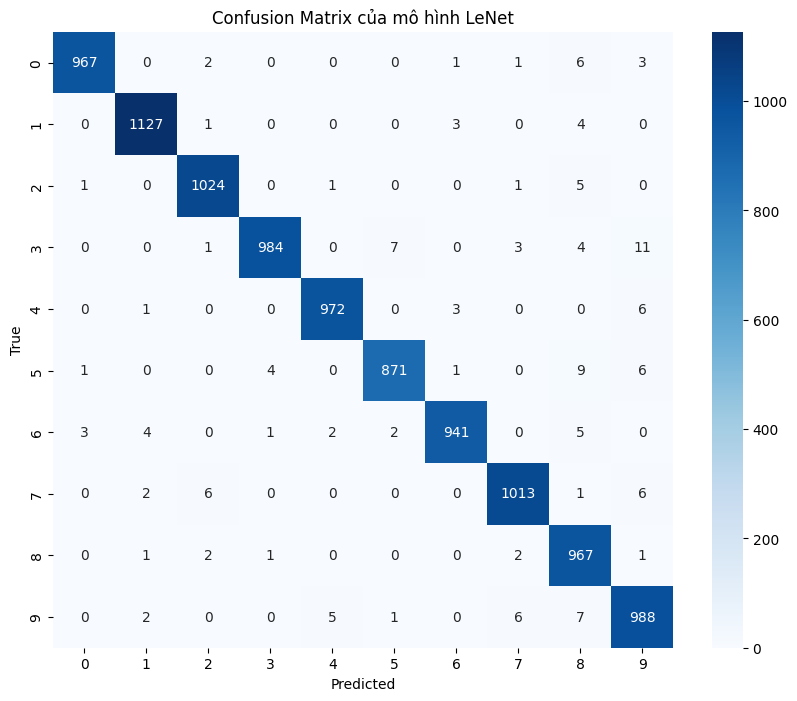


Đang vẽ biểu đồ Loss và Accuracy...


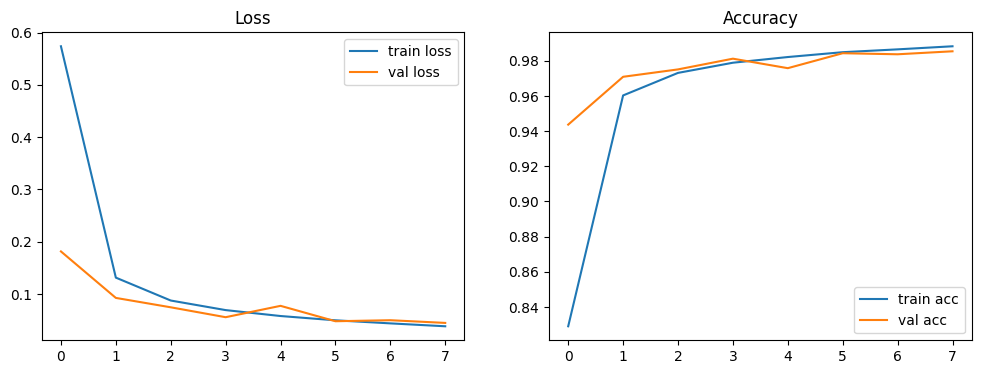

<Figure size 640x480 with 0 Axes>

In [26]:
import sys
sys.path.insert(0, '/content/dl')
%run dl/main_lenet.py